In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


### Bivariate Normal Data Generation

In [3]:
from simulation import get_sampler, cls_to_dset, get_train_test_samples
MU = {
    0: [4, 3],
    1: [3, 1],
    2: [3, 5],
    3: [2, 4]
}
std = 0.2
COV = {
    0: np.eye(2)*std**2,
    1: np.eye(2)*std**2,
    2: np.eye(2)*std**2,
    3: np.eye(2)*std**2
}
K = 4
SAMPLERS = get_sampler(MU, COV, K)
# Get SAMPLES
n = 1000
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_train_test_samples(SAMPLERS=SAMPLERS, n=n)
# Dataset
IND_CLS = [0, 1, 2]
OOD_CLS = [3]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)

#### Plot

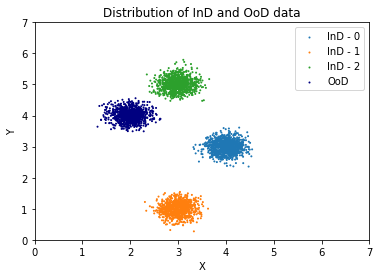

In [565]:
for idx in IND_CLS:
    plt.scatter(IND_X[:,0][IND_Y==idx], IND_X[:,1][IND_Y==idx], label =f"InD - {idx}", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

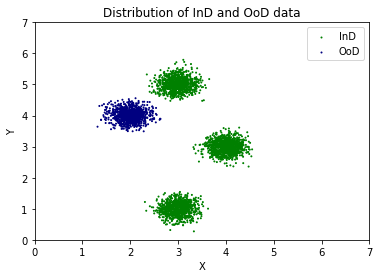

In [566]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

### Naive Classifier Training

In [567]:
from tqdm import tqdm
from simulation import classifier_training
D = DSIM()
# Configuration
max_epoch = 256
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)
torch.save(D.state_dict(), "simulation_log/model/D.pt")

  1%|          | 3/256 [00:00<00:20, 12.46it/s]

Epoch  # 1 | Tri loss: 1.149                     | Tri accuracy: 0.3323
Epoch  # 1 | Val loss: 1.1383                     | Val accuracy: 0.3341


 21%|██        | 53/256 [00:02<00:08, 23.83it/s]

Epoch  # 51 | Tri loss: 0.0343                     | Tri accuracy: 0.9997
Epoch  # 51 | Val loss: 0.0334                     | Val accuracy: 1.0


 41%|████      | 104/256 [00:04<00:06, 23.19it/s]

Epoch  # 101 | Tri loss: 0.0057                     | Tri accuracy: 0.9997
Epoch  # 101 | Val loss: 0.0057                     | Val accuracy: 1.0


 61%|██████    | 155/256 [00:07<00:04, 24.28it/s]

Epoch  # 151 | Tri loss: 0.0023                     | Tri accuracy: 1.0
Epoch  # 151 | Val loss: 0.0024                     | Val accuracy: 1.0


 79%|███████▉  | 203/256 [00:09<00:02, 22.71it/s]

Epoch  # 201 | Tri loss: 0.0013                     | Tri accuracy: 1.0
Epoch  # 201 | Val loss: 0.0013                     | Val accuracy: 1.0


 99%|█████████▉| 254/256 [00:11<00:00, 23.12it/s]

Epoch  # 251 | Tri loss: 0.0008                     | Tri accuracy: 1.0
Epoch  # 251 | Val loss: 0.0008                     | Val accuracy: 1.0


100%|██████████| 256/256 [00:11<00:00, 22.05it/s]


#### Plot

torch.Size([10000, 3])


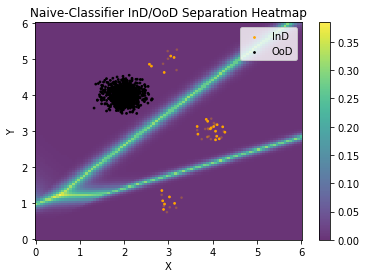

In [568]:
plot_wood = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_X, 
                    D=D, method="Naive-Classifier", m=100)

### WOOD Training

In [5]:
from simulation import *
D_WOOD = DSIM(16)
# OOD data preparation
n_ood = 2
ood_bsz = 8
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
torch.save(OOD_BATCH, "simulation_log/model/ood_batch.pt")
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 128
lr = 1e-3
beta = 0.1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

OOD Batch Shape: torch.Size([2, 2])


  1%|          | 1/128 [00:00<00:54,  2.33it/s]

Epoch  # 1 | Tri loss: 2.3134                     | Tri accuracy: 0.333
Epoch  # 1 | Val loss: 2.0793                     | Val accuracy: 0.3313


  9%|▊         | 11/128 [00:03<00:33,  3.51it/s]

Epoch  # 11 | Tri loss: 0.9431                     | Tri accuracy: 0.6664
Epoch  # 11 | Val loss: 0.8921                     | Val accuracy: 0.6675


 16%|█▋        | 21/128 [00:06<00:30,  3.56it/s]

Epoch  # 21 | Tri loss: 0.6706                     | Tri accuracy: 0.9681
Epoch  # 21 | Val loss: 0.6151                     | Val accuracy: 0.9776


 24%|██▍       | 31/128 [00:09<00:26,  3.60it/s]

Epoch  # 31 | Tri loss: 0.4375                     | Tri accuracy: 0.9949
Epoch  # 31 | Val loss: 0.3936                     | Val accuracy: 0.9958


 32%|███▏      | 41/128 [00:11<00:23,  3.69it/s]

Epoch  # 41 | Tri loss: 0.3074                     | Tri accuracy: 0.9997
Epoch  # 41 | Val loss: 0.2654                     | Val accuracy: 0.9997


 40%|███▉      | 51/128 [00:14<00:20,  3.70it/s]

Epoch  # 51 | Tri loss: 0.2308                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.1911                     | Val accuracy: 1.0


 48%|████▊     | 61/128 [00:17<00:18,  3.68it/s]

Epoch  # 61 | Tri loss: 0.1775                     | Tri accuracy: 1.0
Epoch  # 61 | Val loss: 0.1376                     | Val accuracy: 1.0


 55%|█████▌    | 71/128 [00:20<00:17,  3.24it/s]

Epoch  # 71 | Tri loss: 0.1437                     | Tri accuracy: 1.0
Epoch  # 71 | Val loss: 0.1115                     | Val accuracy: 1.0


 63%|██████▎   | 81/128 [00:22<00:12,  3.78it/s]

Epoch  # 81 | Tri loss: 0.121                     | Tri accuracy: 1.0
Epoch  # 81 | Val loss: 0.083                     | Val accuracy: 1.0


 71%|███████   | 91/128 [00:25<00:09,  3.79it/s]

Epoch  # 91 | Tri loss: 0.1055                     | Tri accuracy: 1.0
Epoch  # 91 | Val loss: 0.0673                     | Val accuracy: 1.0


 79%|███████▉  | 101/128 [00:28<00:07,  3.80it/s]

Epoch  # 101 | Tri loss: 0.0938                     | Tri accuracy: 1.0
Epoch  # 101 | Val loss: 0.0569                     | Val accuracy: 1.0


 87%|████████▋ | 111/128 [00:30<00:04,  3.82it/s]

Epoch  # 111 | Tri loss: 0.085                     | Tri accuracy: 1.0
Epoch  # 111 | Val loss: 0.0481                     | Val accuracy: 1.0


 95%|█████████▍| 121/128 [00:33<00:01,  3.61it/s]

Epoch  # 121 | Tri loss: 0.0784                     | Tri accuracy: 1.0
Epoch  # 121 | Val loss: 0.0415                     | Val accuracy: 1.0


100%|██████████| 128/128 [00:35<00:00,  3.61it/s]


In [570]:
from simulation import calculate_accuracy
calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.95)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.95)
calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.99)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.99)
calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.999)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.999)

0.95: 0.14100000262260437
0.95: 1.0
0.99: 0.007000000216066837
0.99: 1.0
0.999: 0.0
0.999: 0.9929999709129333


0.11491030386090491

### OOD GAN Training

In [12]:
from simulation import *
from wasserstein import *
D_GAN = DSIM(16)
G_GAN = GSIM(16)
# OOD data preparation
# n_ood = 64
ood_bsz = 8
bsz_tri = 64
# OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 128
lr = 1e-3
w_ce, w_wass, w_dist = 1, 0.1, 0.0
n_dim = 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, w_dist,\
                    ind_tri_loader, ind_val_loader, max_epoch, n_epoch=5, n_step_log=10)

OOD Batch Shape: torch.Size([2, 2])


  0%|          | 0/128 [00:00<?, ?it/s]

Step: 0    | D:  1.2413 | CE:  1.2410 | W_OoD:  0.3205 | W_z:  0.3241 | G: -0.0326 | W_z:  0.3261 | dist: 2.9044
Step: 10   | D:  1.2027 | CE:  1.2038 | W_OoD:  0.3540 | W_z:  0.3436 | G: -0.0345 | W_z:  0.3453 | dist: 2.9890


  1%|          | 1/128 [00:14<31:02, 14.67s/it]

Epoch  # 1 | Val accuracy: 0.3342
Step: 8    | D:  1.2356 | CE:  1.2376 | W_OoD:  0.3773 | W_z:  0.3567 | G: -0.0356 | W_z:  0.3563 | dist: 3.0396


  2%|▏         | 2/128 [00:28<29:57, 14.26s/it]

Step: 6    | D:  1.1705 | CE:  1.1712 | W_OoD:  0.3730 | W_z:  0.3662 | G: -0.0367 | W_z:  0.3671 | dist: 2.9703


  2%|▏         | 3/128 [00:42<29:36, 14.21s/it]

Step: 4    | D:  1.1833 | CE:  1.1831 | W_OoD:  0.3740 | W_z:  0.3760 | G: -0.0377 | W_z:  0.3768 | dist: 2.9418


  3%|▎         | 4/128 [00:57<30:05, 14.56s/it]

Step: 2    | D:  1.2122 | CE:  1.2111 | W_OoD:  0.3766 | W_z:  0.3878 | G: -0.0389 | W_z:  0.3886 | dist: 2.8932


  4%|▍         | 5/128 [01:11<29:27, 14.37s/it]

Step: 0    | D:  1.2287 | CE:  1.2276 | W_OoD:  0.3794 | W_z:  0.3902 | G: -0.0390 | W_z:  0.3898 | dist: 2.8679
Step: 10   | D:  1.2029 | CE:  1.2019 | W_OoD:  0.3812 | W_z:  0.3913 | G: -0.0392 | W_z:  0.3915 | dist: 2.8910


  5%|▍         | 6/128 [01:25<28:50, 14.18s/it]

Epoch  # 6 | Val accuracy: 0.3268
Step: 8    | D:  1.1608 | CE:  1.1599 | W_OoD:  0.3826 | W_z:  0.3922 | G: -0.0392 | W_z:  0.3920 | dist: 2.9051


  5%|▌         | 7/128 [01:39<28:34, 14.17s/it]

Step: 6    | D:  1.1356 | CE:  1.1345 | W_OoD:  0.3814 | W_z:  0.3922 | G: -0.0392 | W_z:  0.3924 | dist: 2.9077


  6%|▋         | 8/128 [01:54<28:35, 14.30s/it]

Step: 4    | D:  1.1100 | CE:  1.1093 | W_OoD:  0.3851 | W_z:  0.3925 | G: -0.0393 | W_z:  0.3926 | dist: 2.9105


  7%|▋         | 9/128 [02:07<27:51, 14.05s/it]

Step: 2    | D:  1.0824 | CE:  1.0818 | W_OoD:  0.3874 | W_z:  0.3926 | G: -0.0393 | W_z:  0.3927 | dist: 2.8834


  8%|▊         | 10/128 [02:22<27:45, 14.11s/it]

Step: 0    | D:  1.0521 | CE:  1.0518 | W_OoD:  0.3891 | W_z:  0.3927 | G: -0.0393 | W_z:  0.3927 | dist: 2.8660
Step: 10   | D:  1.0373 | CE:  1.0368 | W_OoD:  0.3884 | W_z:  0.3928 | G: -0.0393 | W_z:  0.3928 | dist: 2.8621


  9%|▊         | 11/128 [02:36<27:34, 14.14s/it]

Epoch  # 11 | Val accuracy: 0.6672
Step: 8    | D:  1.0373 | CE:  1.0369 | W_OoD:  0.3882 | W_z:  0.3928 | G: -0.0393 | W_z:  0.3928 | dist: 2.8626


  9%|▉         | 12/128 [02:52<28:11, 14.58s/it]

Step: 6    | D:  1.0341 | CE:  1.0336 | W_OoD:  0.3885 | W_z:  0.3929 | G: -0.0393 | W_z:  0.3928 | dist: 2.8464


 10%|█         | 13/128 [03:07<28:24, 14.82s/it]

Step: 4    | D:  1.0222 | CE:  1.0216 | W_OoD:  0.3869 | W_z:  0.3929 | G: -0.0393 | W_z:  0.3929 | dist: 2.8373


 11%|█         | 14/128 [03:22<28:06, 14.79s/it]

Step: 2    | D:  0.9962 | CE:  0.9956 | W_OoD:  0.3871 | W_z:  0.3929 | G: -0.0393 | W_z:  0.3929 | dist: 2.8431


 12%|█▏        | 15/128 [03:36<27:42, 14.71s/it]

Step: 0    | D:  0.9776 | CE:  0.9770 | W_OoD:  0.3866 | W_z:  0.3928 | G: -0.0393 | W_z:  0.3928 | dist: 2.8382
Step: 10   | D:  0.9833 | CE:  0.9828 | W_OoD:  0.3874 | W_z:  0.3929 | G: -0.0393 | W_z:  0.3928 | dist: 2.8492


 12%|█▎        | 16/128 [03:52<28:05, 15.05s/it]

Epoch  # 16 | Val accuracy: 0.6528
Step: 8    | D:  1.0029 | CE:  1.0023 | W_OoD:  0.3871 | W_z:  0.3929 | G: -0.0393 | W_z:  0.3929 | dist: 2.8363


 13%|█▎        | 17/128 [04:06<27:27, 14.84s/it]

Step: 6    | D:  0.9763 | CE:  0.9757 | W_OoD:  0.3877 | W_z:  0.3929 | G: -0.0393 | W_z:  0.3929 | dist: 2.8344


 14%|█▍        | 18/128 [04:21<27:12, 14.84s/it]

Step: 4    | D:  0.9509 | CE:  0.9504 | W_OoD:  0.3878 | W_z:  0.3929 | G: -0.0393 | W_z:  0.3928 | dist: 2.8218


 15%|█▍        | 19/128 [04:36<27:07, 14.93s/it]

Step: 2    | D:  0.9344 | CE:  0.9338 | W_OoD:  0.3869 | W_z:  0.3928 | G: -0.0393 | W_z:  0.3926 | dist: 2.7974


 16%|█▌        | 20/128 [04:51<26:50, 14.91s/it]

Step: 0    | D:  0.9297 | CE:  0.9293 | W_OoD:  0.3880 | W_z:  0.3927 | G: -0.0393 | W_z:  0.3927 | dist: 2.7679
Step: 10   | D:  0.9380 | CE:  0.9375 | W_OoD:  0.3874 | W_z:  0.3927 | G: -0.0393 | W_z:  0.3926 | dist: 2.7504


 16%|█▋        | 21/128 [05:05<26:16, 14.73s/it]

Epoch  # 21 | Val accuracy: 0.6528
Step: 8    | D:  0.9425 | CE:  0.9420 | W_OoD:  0.3873 | W_z:  0.3927 | G: -0.0393 | W_z:  0.3926 | dist: 2.7241


 17%|█▋        | 22/128 [05:19<25:27, 14.41s/it]

Step: 6    | D:  0.8796 | CE:  0.8789 | W_OoD:  0.3856 | W_z:  0.3928 | G: -0.0393 | W_z:  0.3928 | dist: 2.7197


 18%|█▊        | 23/128 [05:33<24:56, 14.26s/it]

Step: 4    | D:  0.9108 | CE:  0.9102 | W_OoD:  0.3876 | W_z:  0.3929 | G: -0.0393 | W_z:  0.3928 | dist: 2.7242


 19%|█▉        | 24/128 [05:47<24:41, 14.25s/it]

Step: 2    | D:  0.9012 | CE:  0.9006 | W_OoD:  0.3865 | W_z:  0.3928 | G: -0.0393 | W_z:  0.3928 | dist: 2.7473


 20%|█▉        | 25/128 [06:02<24:29, 14.27s/it]

Step: 0    | D:  0.9020 | CE:  0.9015 | W_OoD:  0.3870 | W_z:  0.3928 | G: -0.0393 | W_z:  0.3928 | dist: 2.7603
Step: 10   | D:  0.8596 | CE:  0.8590 | W_OoD:  0.3870 | W_z:  0.3928 | G: -0.0393 | W_z:  0.3928 | dist: 2.7576


 20%|██        | 26/128 [06:16<24:05, 14.17s/it]

Epoch  # 26 | Val accuracy: 0.6551
Step: 8    | D:  0.8778 | CE:  0.8770 | W_OoD:  0.3843 | W_z:  0.3929 | G: -0.0393 | W_z:  0.3928 | dist: 2.7575


 21%|██        | 27/128 [06:29<23:36, 14.02s/it]

Step: 6    | D:  0.8734 | CE:  0.8728 | W_OoD:  0.3870 | W_z:  0.3929 | G: -0.0393 | W_z:  0.3929 | dist: 2.7648


 22%|██▏       | 28/128 [06:43<23:17, 13.98s/it]

Step: 4    | D:  0.8661 | CE:  0.8655 | W_OoD:  0.3869 | W_z:  0.3929 | G: -0.0393 | W_z:  0.3929 | dist: 2.7666


 23%|██▎       | 29/128 [06:57<22:52, 13.87s/it]

Step: 2    | D:  0.8310 | CE:  0.8301 | W_OoD:  0.3833 | W_z:  0.3927 | G: -0.0393 | W_z:  0.3926 | dist: 2.7706


 23%|██▎       | 30/128 [07:11<22:43, 13.92s/it]

Step: 0    | D:  0.8315 | CE:  0.8309 | W_OoD:  0.3871 | W_z:  0.3928 | G: -0.0393 | W_z:  0.3927 | dist: 2.7718
Step: 10   | D:  0.8387 | CE:  0.8379 | W_OoD:  0.3849 | W_z:  0.3927 | G: -0.0393 | W_z:  0.3928 | dist: 2.7760


 24%|██▍       | 31/128 [07:25<22:44, 14.07s/it]

Epoch  # 31 | Val accuracy: 0.6643
Step: 8    | D:  0.7836 | CE:  0.7822 | W_OoD:  0.3791 | W_z:  0.3930 | G: -0.0393 | W_z:  0.3927 | dist: 2.7800


 25%|██▌       | 32/128 [07:39<22:20, 13.96s/it]

Step: 6    | D:  0.8094 | CE:  0.8086 | W_OoD:  0.3849 | W_z:  0.3930 | G: -0.0393 | W_z:  0.3927 | dist: 2.7831


 26%|██▌       | 33/128 [07:53<22:19, 14.10s/it]

### Plot

#### Plot Naive Classifier

In [593]:
m, n_ind, n_ood = 300, 25, 25
xi = np.linspace(0, 6, m, endpoint=True)
yi = np.linspace(0, 6, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([90000, 3])


In [594]:
threshold =calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.99)
mask = si > threshold

0.99: 0.007000000216066837


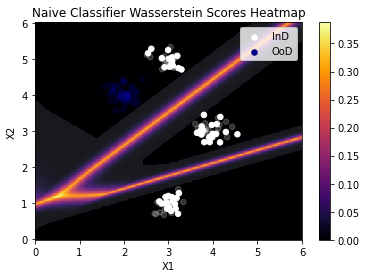

In [595]:
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
n_ind, n_ood = 50, 50, 
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ood, replace=False)
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.title(f"Naive Classifier Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.savefig(f"simulation_log/plot/example_naive.jpg", dpi=1000)

#### Plot WOOD

In [571]:
m, n_ind, n_ood = 100, 25, 25
xi = np.linspace(0, 6, m, endpoint=True)
yi = np.linspace(0, 6, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_WOOD(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([10000, 3])


0.99: 1.0


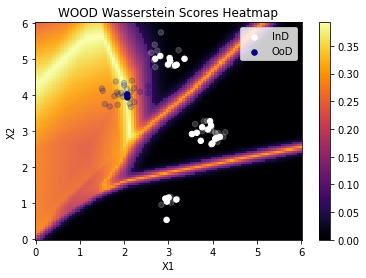

In [572]:
threshold =calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.99)
mask = si > threshold
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ind, replace=False)
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.title(f"WOOD Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.savefig(f"simulation_log/plot/example_wood.jpg", dpi=1000)

#### Plot GAN

In [590]:
m, n_ind, n_ood = 200, 25, 25
xi = np.linspace(0, 6, m, endpoint=True)
yi = np.linspace(0, 6, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi_gan = torch.softmax(D_GAN(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi_gan.shape)
si_gan = ood_wass_loss(zi_gan)

torch.Size([40000, 3])


In [591]:
threshold =calculate_accuracy(D=D_GAN, ind=IND_X, ood=OOD_X, tnr=0.99)
mask = si_gan > threshold

0.99: 1.0


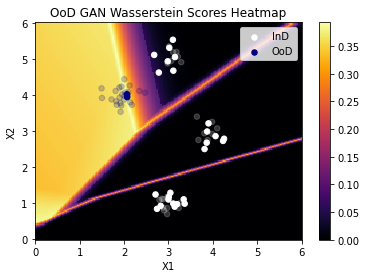

In [592]:
# plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
plt.pcolormesh(xi, yi, si_gan.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ind, replace=False)
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.title(f"OoD GAN Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.savefig(f"simulation_log/plot/example.jpg", dpi=1000)

### Save

In [556]:
torch.save(D, "simulation_log/example/D.pt")
torch.save(D_WOOD, "simulation_log/example/D_WOOD.pt")
torch.save(D_GAN, "simulation_log/example/D_GAN.pt")
torch.save(G_GAN, "simulation_log/example/G_GAN.pt")
torch.save(OOD_BATCH,"simulation_log/example/OOD_BATCH.pt")
torch.save(OOD_X,"simulation_log/example/OOD_X.pt")
torch.save(OOD_X_TEST,"simulation_log/example/OOD_X_TEST.pt")
torch.save(IND_X,"simulation_log/example/IND_X.pt")
torch.save(IND_X_TEST,"simulation_log/example/IND_X_TEST.pt")
torch.save(IND_Y,"simulation_log/example/IND_Y.pt")
torch.save(IND_Y_TEST,"simulation_log/example/IND_Y_TEST.pt")
torch.save(SAMPLERS, 'simulation_log/example/samplers.pt')
torch.save((X_TRAIN, Y_TRAIN, X_TEST, Y_TEST), 'simulation_log/example/raw_data.pt')